In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
import os

import requests
from transformers import BlipProcessor, BlipForQuestionAnswering,AutoModel,AutoProcessor
from datasets import load_dataset
import torch
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.cuda.empty_cache()
# torch.manual_seed(42)




2024-04-20 03:35:53.111790: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 03:35:53.872130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [55]:
print(model)

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [3]:
from peft import LoraConfig, TaskType

lora_config = LoraConfig(
    r=32,
    target_modules=["query", "value"],
    lora_alpha=32,
    lora_dropout=0.05
)

In [4]:
from peft import get_peft_model

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 4,718,592 || all params: 389,391,164 || trainable%: 1.2117871272497596


In [5]:
# class VQADataset(torch.utils.data.Dataset):
#     """VQA (v2) dataset."""

#     def __init__(self, dataset, processor):
#         self.dataset = dataset
#         self.processor = processor

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         # get image + text
#         question = self.dataset[idx]['question']
#         answer = self.dataset[idx]['answer']
#         image_id = self.dataset[idx]['pid']
#         image_path = f"/content/blip-vqa-finetune/Data/IconDomainVQAData/train_fill_in_blank/train_fill_in_blank/{image_id}/image.png"
#         image = Image.open(image_path).convert("RGB")
#         text = question

#         encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
#         labels = self.processor.tokenizer.encode(
#             answer, max_length= 8, pad_to_max_length=True, return_tensors='pt'
#         )
#         encoding["labels"] = labels
#         # remove batch dimension
#         for k,v in encoding.items():  encoding[k] = v.squeeze()
#         return encoding


# import os
# import torch
# from PIL import Image

# class VQADataset(torch.utils.data.Dataset):
#     """VQA (v2) dataset for a specific medical image QA task."""

#     def __init__(self, dataset, processor, image_dir):
#         self.processor = processor
#         self.image_dir = image_dir
#         # Filter dataset to include only entries with available images
#         self.dataset = [entry for entry in dataset if self._image_exists(entry['id'])]

#     def _image_exists(self, image_id):
#         image_path = os.path.join(self.image_dir, f"{image_id}.jpg")
#         return os.path.exists(image_path)

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         entry = self.dataset[idx]
#         print(entry)
#         conversations = entry['conversations']
#         question, answer = None, None
#         for i in range(len(conversations)):
#             if conversations[i]['from'] == 'human':
#                 question = conversations[i]['value']
#                 if i + 1 < len(conversations) and conversations[i + 1]['from'] == 'gpt':
#                     answer = conversations[i + 1]['value']
#                 break

#         image_id = entry['id']
#         image_path = os.path.join(self.image_dir, f"{image_id}.jpg")
#         image = Image.open(image_path).convert("RGB")
#         text = question if question is not None else ""

#         encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
#         labels = self.processor.tokenizer.encode(
#             answer, max_length=8, pad_to_max_length=True, return_tensors='pt'
#         ) if answer is not None else None

#         encoding["labels"] = labels
#         for k, v in encoding.items():
#             encoding[k] = v.squeeze()

#         return encoding






Generating train split: 0 examples [00:00, ? examples/s]

Training sets: 1 


In [10]:
import os
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):
    """VQA dataset specialized for medical image QA with choices and a detailed answer format."""

    def __init__(self, dataset, processor, image_dir):
        self.processor = processor
        self.image_dir = image_dir
        self.dataset = [entry for entry in dataset]

    def _image_exists(self, image_path):
        full_path = os.path.join(self.image_dir, image_path)
        return os.path.exists(full_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        entry = self.dataset[idx]

        # Retrieve the image
        image_path = os.path.join(self.image_dir, entry['Figure_path'])
        image = Image.open(image_path).convert("RGB")

        # Question and answer formation
        question = entry['Question'].strip()
        caption = entry['Caption']
        answer_label = entry['Answer']
        answer_choice = entry[f'Choice {answer_label}']
        # answer=entry[answer_choice]
        answer_text = f"{answer_choice[3:]} as, the image is about {caption}"
        # print(answer_text)
        # Encode the image and text for the model
        encoding = self.processor(image, question, padding="max_length", truncation=True, return_tensors="pt")
        labels = self.processor.tokenizer.encode(
            answer_text, max_length=50, pad_to_max_length=True, return_tensors='pt'
        )

        encoding["labels"] = labels.squeeze()  # Remove batch dimension
        for k, v in encoding.items():
            if k != 'labels':  # labels are already squeezed
                encoding[k] = v.squeeze()

        return encoding
# dataset = load_dataset("rbojja/medical-vqa")
training_dataset = load_dataset("csv", data_files="train_2.csv",split="train[:20%]")
# valid_dataset = load_dataset("rbojja/medical-vqa",split="test")
print("Training sets: {} ".format(len(training_dataset)))


Training sets: 30521 


In [62]:
training_dataset[2]

{'index': 41,
 'Figure_path': 'PMC8253797_Fig4_15.jpg',
 'Caption': 'A slightly altered cell . (c-c‴) A highly altered cell as seen from 4 different angles . Note mitochondria/mitochondrial networks (green), Golgi complexes (red), cell nuclei (light blue) and the cell outline (yellow).',
 'Question': 'What is labeled in red in the image? ',
 'Choice A': ' A:Golgi complexes ',
 'Choice B': ' B:Cell nuclei ',
 'Choice C': ' C:Lysosomes ',
 'Choice D': ' D:Mitochondria/mitochondrial networks  ',
 'Answer': 'A',
 'split': 'train'}

In [25]:
# train_dataset = VQADataset(dataset=training_dataset,
#                           processor=processor)
# batch_size = 12
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [49]:
# train_dataset[0]

In [11]:
train_dataset = VQADataset(dataset=training_dataset,
                          processor=processor,image_dir='figures')
# valid_dataset = VQADataset(dataset=valid_dataset,
#                           processor=processor)

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)



In [12]:
num_epochs = 20
patience = 10
min_eval_loss = float("inf")
early_stopping_hook = 0
tracking_information = []
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for idx, batch in zip(tqdm(range(len(train_dataloader)), desc='Training batch: ...'), train_dataloader):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_masked = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        attention_mask=attention_masked,
                        labels=labels)

        loss = outputs.loss
        # print(loss,outputs.text_model_output)
        epoch_loss += loss.item()
        # loss.backward()
        # optimizer.step()
        optimizer.zero_grad()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    # model.eval()
    # eval_loss = 0
    # for idx, batch in zip(tqdm(range(len(valid_dataloader)), desc='Validating batch: ...'), valid_dataloader):
    #     input_ids = batch.pop('input_ids').to(device)
    #     pixel_values = batch.pop('pixel_values').to(device)
    #     attention_masked = batch.pop('attention_mask').to(device)
    #     labels = batch.pop('labels').to(device)

    #     with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
    #         outputs = model(input_ids=input_ids,
    #                     pixel_values=pixel_values,
    #                     attention_mask=attention_masked,
    #                     labels=labels)

    #     loss = outputs.loss
    #     eval_loss += loss.item()

    # tracking_information.append((epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader), optimizer.param_groups[0]["lr"]))
    # print("Epoch: {} - Training loss: {} - Eval Loss: {} - LR: {}".format(epoch+1, epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader), optimizer.param_groups[0]["lr"]))
    # scheduler.step()
    if epoch_loss < min_eval_loss:
        model.save_pretrained("Model/blip-saved-model", from_pt=True)
        print("Saved model to Model/blip-saved-model")
        min_eval_loss = epoch_loss
        early_stopping_hook = 0
    else:
        early_stopping_hook += 1
        if early_stopping_hook > patience:
            break

pickle.dump(tracking_information, open("tracking_information.pkl", "wb"))
print("The finetuning process has done!")

Training batch: ...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [26:00<00:00,  2.45it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:56<00:00,  2.45it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:53<00:00,  2.46it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:55<00:00,  2.45it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [26:01<00:00,  2.44it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:56<00:00,  2.45it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:52<00:00,  2.46it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:54<00:00,  2.46it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:55<00:00,  2.45it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [26:04<00:00,  2.44it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:57<00:00,  2.45it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:55<00:00,  2.45it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:58<00:00,  2.45it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:54<00:00,  2.45it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:58<00:00,  2.45it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:57<00:00,  2.45it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [26:02<00:00,  2.44it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:56<00:00,  2.45it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:55<00:00,  2.45it/s]


Saved model to Model/blip-saved-model


Training batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3816/3816 [25:55<00:00,  2.45it/s]


Saved model to Model/blip-saved-model
The finetuning process has done!


In [22]:
# !wget 'https://huggingface.co/datasets/xmcmic/PMC-VQA/resolve/main/images_2.zip?download=true'

In [26]:
# !ls

In [8]:
# !unzip images_2.zip?download=true

In [9]:
# pip install peft

In [10]:
# pip install datasets

In [28]:
from transformers import BlipProcessor, BlipForQuestionAnswering
import requests
from PIL import Image
import json, os, csv
import logging
from tqdm import tqdm
import torch


In [29]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Model/blip-saved-model").to("cuda")

OSError: Model/blip-saved-model does not appear to have a file named config.json. Checkout 'https://huggingface.co/Model/blip-saved-model/main' for available files.

FileUpload(value={}, accept='image/*', description='Upload')

Text(value='', description='Question:', placeholder='Type your question here...')

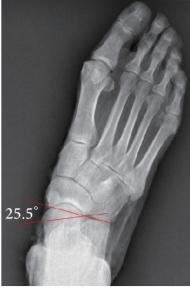

Answer: the ankle is in the lower right corner


In [24]:
import torch
from PIL import Image
import io
from IPython.display import display
from ipywidgets import widgets

# Assuming 'processor' and 'model' are already defined and loaded
def process_image_and_question(change):
    if upload_button.value:
        # Get the image file
        uploaded_file = next(iter(upload_button.value.values()))
        image_data = uploaded_file['content']
        image = Image.open(io.BytesIO(image_data)).convert("RGB")

        # Display the uploaded image
        display(image)

        # Read the question from the text widget
        question = question_input.value

        # Prepare inputs
        encoding = processor(image, question, return_tensors="pt").to("cuda:0", torch.float16)

        # Generate output from the model
        out = model.generate(**encoding)
        generated_text = processor.decode(out[0], skip_special_tokens=True)

        # Display the generated text
        print("Answer:", generated_text)

# Create widgets
upload_button = widgets.FileUpload(
    accept='image/*',  # Accept image/* means it can accept any type of image
    multiple=False  # Allow only single file upload
)

question_input = widgets.Text(
    description='Question:',
    placeholder='Type your question here...'
)

# Set up event to trigger on file upload
upload_button.observe(process_image_and_question, names='value')

# Display widgets
display(upload_button, question_input)


In [19]:
!zip -r Model_blip_medvqa_epoch1.zip /content/Model_blip_medvqa_epoch1

  adding: content/Model_blip_medvqa_epoch1/ (stored 0%)
  adding: content/Model_blip_medvqa_epoch1/blip-saved-model/ (stored 0%)
  adding: content/Model_blip_medvqa_epoch1/blip-saved-model/adapter_model.safetensors (deflated 7%)
  adding: content/Model_blip_medvqa_epoch1/blip-saved-model/README.md (deflated 66%)
  adding: content/Model_blip_medvqa_epoch1/blip-saved-model/adapter_config.json (deflated 52%)
